# Aug 19th, 2022 (Degree: w/o regression)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
nn = 512
mice = Mice(nn)
n_nodes = len(mice.node_lookup['ca2'])

kwargs = {
    'mice': mice,
    'mode': 'bold-lite',
    'prep_data': True,
}

In [3]:
%%time

for desc in ['raw', 'rabies-hp', 'rabies-nocr', 'rabies-nowmcsf']:
    mice.setup_func_data(desc={'bold': desc})
    a = np_nans((len(mice.bold), n_nodes, n_nodes))
    for i, key in enumerate(mice.bold):
        bs = Base(key=key, **kwargs)
        a[i] = get_adj_mat(
            x=bs.data,
            metric='pearson',
            p_val=1.0,
        )[0]
    np.save(pjoin(tmp_dir, f'adj_{desc}.npy'), a)

CPU times: user 3min 14s, sys: 15min 1s, total: 18min 15s
Wall time: 19min 34s


In [98]:
adj = {}
for desc in ['raw', 'rabies-nocr', 'rabies-nowmcsf', 'rabies-hp']:
    adj[desc] = np.load(pjoin(tmp_dir, f'adj_{desc}.npy'))

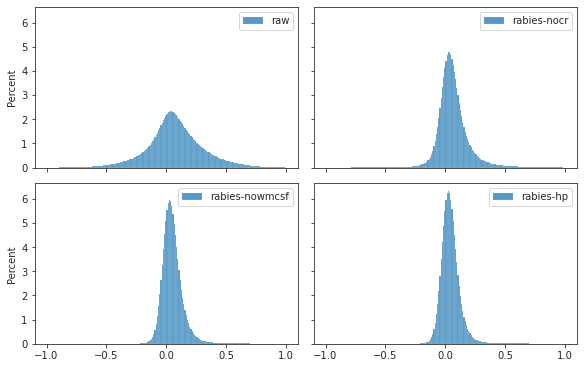

In [99]:
fig, axes = create_figure(2, 2, (8, 5), 'all', 'all', constrained_layout=True)
for i, (desc, a) in enumerate(adj.items()):
    ax = axes.flat[i]
    sns.histplot(
        data=a[a.nonzero()],
        label=desc,
        bins=np.linspace(-1, 1, 201),
        stat='percent',
        ax=ax,
    )
    ax.legend()
plt.show()

In [100]:
df = []
degree = {}
adj_bin = {}
for desc, a_all in adj.items():
    deg = np_nans(a_all.shape[:2])
    a_bin = np_nans(a_all.shape)
    for i, a in enumerate(a_all):
        th = calculate_threshold(a, 0.15)
        th = th.pop()
        df.append({
            'th': [th],
            'desc': [desc],
            'run': [i + 1],
        })
        # Binarize
        _a = a.copy()
        _a[a <= th] = 0
        _a[a > th] = 1
        a_bin[i] = _a
        # Degree
        nan = np.isnan(a).sum(0) == len(a)
        zero = np.nanmean(np.abs(a), 0) == 0
        good = np.logical_and(~nan, ~zero)
        a_eff = _a[good][:, good]
        deg[i] = _a.sum(0)
    degree[desc] = deg
    adj_bin[desc] = a_bin
df = pd.DataFrame(merge_dicts(df))
degree_avg = {k: bn.nanmean(v, 0) for k, v in degree.items()}

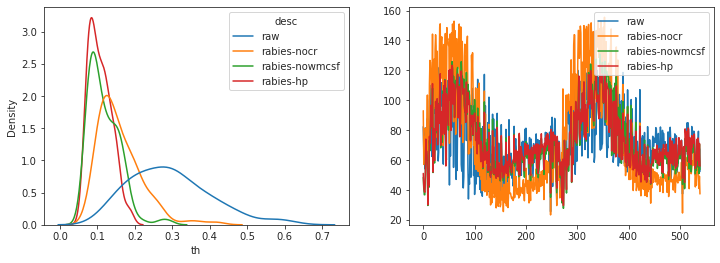

In [101]:
fig, axes = create_figure(1, 2, (12, 4))
sns.kdeplot(data=df, x='th', hue='desc', ax=axes[0])
for k, v in degree_avg.items():
    axes[1].plot(v, label=k)
axes[1].legend()
plt.show()

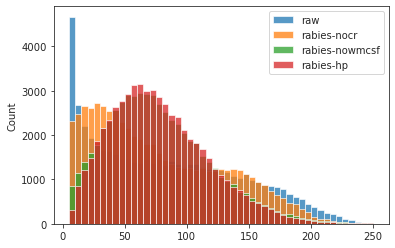

In [109]:
for i, (desc, x) in enumerate(degree.items()):
    sns.histplot(x[x.nonzero()], color=f'C{i}', label=desc, bins=np.linspace(5, 250, 50))
plt.legend()
plt.show()

In [102]:
bs = Base(mice, mode='ca2')

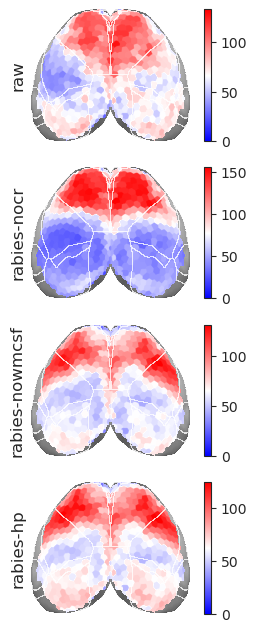

In [108]:
_ = bs.show(
    degree_avg,
    vmin=0,
    vmax=None,
    cmap='bwr',
    cbar=True,
    figsize=(4, 8),
)